![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---



# Task 6 - Data Augmentation

In the previous exercise, you have successfully built a classification model using the Tensorflow library.
This time we will learn how to use the tensorflow library to augment data and help improve the training performance.



---
## GPU Runtime
Since we're going to use TensorFlow, we can utilize the GPU to accelerate the process

For that, make sure that this Colaboratory file is set to use GPU

* select **Runtime** in taskbar
* select **Change Runtime Type**
* choose Hardware accelerator **GPU**

<center>
  
![gpu](https://i.ibb.co/QX3Brf0/gpu.png)


---
---
#[Part 0] Import Libraries and Load Data

Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM = 1301170073
Nama = "Pratama Yoga S"

## --- end your code here ----

---
## 1 - Import Libraries

Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=7)

---
## 2 - Load CIFAR-10

In [3]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)
print('X_test.shape  =',X_test.shape)
print('y_test.shape  =',y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)


like always, let's visualize it first

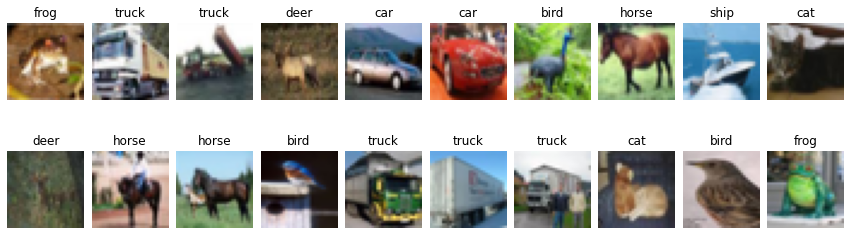

In [4]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train[i+j*10])
        ax[j,i].set_title(classes[y_train[i+j*10,0]])
        ax[j,i].axis('off')
plt.show()

---
## 3 - Split Validation Data

In [5]:
X_val = X_train[-10000:,:]
y_val = y_train[-10000:]

X_train = X_train[:-10000, :]
y_train = y_train[:-10000]

print('X_val.shape   =',X_val.shape)
print('y_val.shape   =',y_val.shape)
print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)

X_val.shape   = (10000, 32, 32, 3)
y_val.shape   = (10000, 1)
X_train.shape = (40000, 32, 32, 3)
y_train.shape = (40000, 1)


---
## 4 - Normalize and Reshape Data

In [6]:

mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)

X_train = (X_train - mean_pixel) / std_pixel
X_val   = (X_val - mean_pixel) / std_pixel
X_test  = (X_test - mean_pixel) / std_pixel

X_train = X_train.astype('float32')
X_val   = X_val.astype('float32')
X_test  = X_test.astype('float32')

print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)


X_train.shape = (40000, 32, 32, 3)
X_val.shape   = (10000, 32, 32, 3)
X_test.shape  = (10000, 32, 32, 3)


Somehow the Augmentation API is performing better when the label is in one-hot categorical. So let's just do that.

In [7]:
from tensorflow.keras.utils import to_categorical

y_train_hot = to_categorical(y_train.ravel(), 10)
y_val_hot = to_categorical(y_val.ravel(), 10)
y_test_hot = to_categorical(y_test.ravel(), 10)

print('y_train_hot.shape =',y_train_hot.shape)
print('y_val_hot.shape   =',y_val_hot.shape)
print('y_test_hot.shape  =',y_test_hot.shape)

y_train_hot.shape = (40000, 10)
y_val_hot.shape   = (10000, 10)
y_test_hot.shape  = (10000, 10)


---
## 5 - Helper Functions


### a. Plot History 
Below is a function to plot the training and validation accuracy, as well the training and validation loss during the training process


In [8]:
def plot_history(history):
    plt.rcParams['figure.figsize'] = [14, 3.5]
    plt.subplots_adjust(wspace=0.2)

    plt.subplot(121)
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'])

    plt.subplot(122)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'])
    plt.show()

### b. Plot Augmentation Result
Below is a function to show augmentation results from a data generator


In [9]:
def plot_augmentation(data_generator, nrows=1, ncols=4, figsize=(20,6)):

    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    if len(ax.shape) == 1:
        ax = np.expand_dims(ax,0)
    for i in range(nrows):
        for j in range(ncols):
            image = image_iterator.next()[0].astype('int')
            ax[i,j].imshow(image)
            ax[i,j].axis('off')
    plt.show()

---
---

# [Part 1] Three-Layer ConvNet
In this exercise, to easily compare the result between model trained with and without Augmentation, let's build a fairly simple network

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D

num_data    = X_train.shape[0]
X_dim       = X_train.shape[1]
num_classes = y_train_hot.shape[1]

---
## 1 - Define Model

Define a five-layer convolutional network with the following architecture:

<pre>
1. <font color='red'>16 @3x3 Conv2D</font>, activation=relu, padding=same, 
   input_shape=(32,32,3),
2. <font color='red'>32 @3x3 Conv2D</font>, activation=relu, padding=same,
3. <font color='blue'>MaxPool2D</font>,
4. <font color='red'>64 @3x3 Conv2D</font>, activation=relu, padding=same,
5. <font color='blue'>MaxPool2D</font>,
6. Flatten,
7. <font color='red'>Dense 128</font>, activation=relu, 
8. <font color='red'>Dense num_classes</font>, activation=softmax, 
</pre>

#### <font color='red'>**EXERCISE:** </font>
complete the function


In [11]:
# create model compact sequential
def create_model(model_name = 'myModel'):
    model = Sequential([
        Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        MaxPool2D(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model


Show the model summary

In [12]:
model = create_model()

model.summary()

Model: "myModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               5244

**EXPECTED OUTPUT**:
<pre>
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_? (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_? (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_? (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_? (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_? (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense_? (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_? (Dense)              (None, 10)                1290      
=================================================================
Total params: 549,290
Trainable params: 549,290
Non-trainable params: 0
_________________________________________________________________

let's also plot the model design

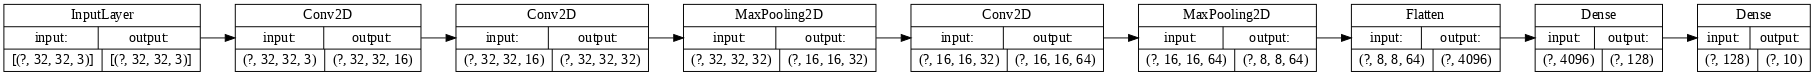

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file=model.name+'.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='LR',
           dpi=70
          )


**EXPECTED OUTPUT**:

<img src="https://i.ibb.co/7RLjxJ8/5layerconv.png">

---
---
# [Part 2] Training without Augmentation

---
## 1 - Build Model

#### <font color='red'>**EXERCISE:** </font>
Build the model by calling `create_model()` function. 


In [14]:
model_no_aug = create_model()

---
## 2 - Compile Model

#### <font color='red'>**EXERCISE:** </font>
compile your model using `'categorical_crossentropy'` loss, `'adam'` optimizer, and `['accuracy']` metrics


In [15]:
model_no_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

---
## 3 - Train Model

#### <font color='red'>**EXERCISE:** </font>
Train the model for `20` epochs with batch size of `256`.<br>
Don't forget to put the validation data.<br>
Use the one-hot label.


In [16]:
num_epochs = 20
batch_size = 256

history_no_aug = model_no_aug.fit(X_train, y_train_hot, 
                    validation_data=(X_val, y_val_hot),
                    epochs=num_epochs, 
                    batch_size=batch_size,)

Epoch 1/20
157/157 [==============================] - 2s 14ms/step - loss: 1.4962 - accuracy: 0.4672 - val_loss: 1.2398 - val_accuracy: 0.5658
Epoch 2/20
157/157 [==============================] - 2s 12ms/step - loss: 1.0785 - accuracy: 0.6221 - val_loss: 1.0733 - val_accuracy: 0.6256
Epoch 3/20
157/157 [==============================] - 2s 12ms/step - loss: 0.9186 - accuracy: 0.6792 - val_loss: 0.9495 - val_accuracy: 0.6711
Epoch 4/20
157/157 [==============================] - 2s 12ms/step - loss: 0.8209 - accuracy: 0.7150 - val_loss: 0.9119 - val_accuracy: 0.6878
Epoch 5/20
157/157 [==============================] - 2s 12ms/step - loss: 0.7220 - accuracy: 0.7507 - val_loss: 0.8784 - val_accuracy: 0.6971
Epoch 6/20
157/157 [==============================] - 2s 12ms/step - loss: 0.6497 - accuracy: 0.7754 - val_loss: 0.8971 - val_accuracy: 0.7030
Epoch 7/20
157/157 [==============================] - 2s 12ms/step - loss: 0.5690 - accuracy: 0.8035 - val_loss: 0.9128 - val_accuracy: 0.7021

**EXPECTED OUTPUT**:

<pre>The loss should start from ~1.5 and end around 0.05 with training accuracy around 98%, 
but with validation accuracy stuck at 70%

---
## 4 - Evaluate Model


#### <font color='red'>**EXERCISE:** </font>
Evaluate model using data test.<br>
Use the one-hot label.


In [17]:
scores_no_aug = model_no_aug.evaluate(X_test, y_test_hot, verbose=1)

print("\nModel Accuracy: %.2f%%" % (scores_no_aug[1]*100))

313/313 [==============================] - 1s 2ms/step - loss: 2.0087 - accuracy: 0.6905

Model Accuracy: 69.05%


**EXPECTED OUTPUT**:
<pre>
you should get around 70% of testing accuracy

---
## 5 - Visualize Training History

Visualize the train-validation accuracy

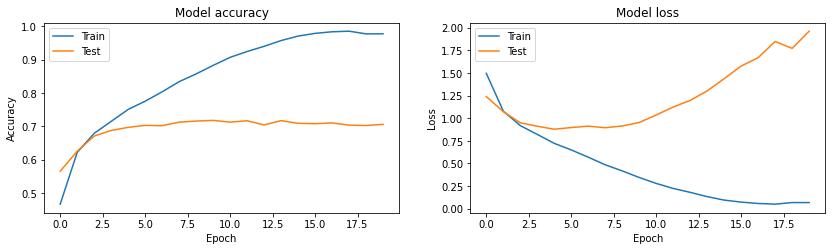

In [18]:
plot_history(history_no_aug)

The Training Accuracy is close to 100%, and the validation accuracy is in the 70% range.

This is a great example of overfitting -- which in short means that it can do very well with images it has seen before, but not so well with images it hasn't. 

At this point, we cannot continue training to improve the performance.

---
# [Part 3] Image Augmentation

Let's see if we can do better to avoid overfitting -- and one simple method is to augment the images a bit. If you think about it, most pictures of a cat are very similar -- the ears are at the top, then the eyes, then the mouth etc. Things like the distance between the eyes and ears will always be quite similar too. 

What if we tweak with the images to change this up a bit -- rotate the image, squash it, etc.  That's what image augementation is all about. And there's an API that makes it easy...

Now take a look at the ImageGenerator. There are properties on it that you can use to augment the image

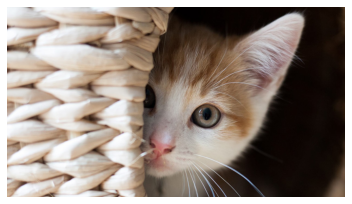

In [19]:
!wget -q -O 'image.jpg' 'https://www.humanesociety.org/sites/default/files/styles/1240x698/public/2018/08/kitten-440379.jpg'

image = plt.imread("image.jpg")
images = np.expand_dims(image, 0)

plt.imshow(images[0])
plt.axis('off')
plt.show()

These are just a few of the options available (for more, see the Keras documentation. Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


Here's some code where we've added Image Augmentation. Run it to see the impact.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

---
## 1 - Rotation
By specifying the `rotation_range` , the data generated is randomly rotated by an angle in the range of `+rotation_range` to `-rotation_range` (in degrees).

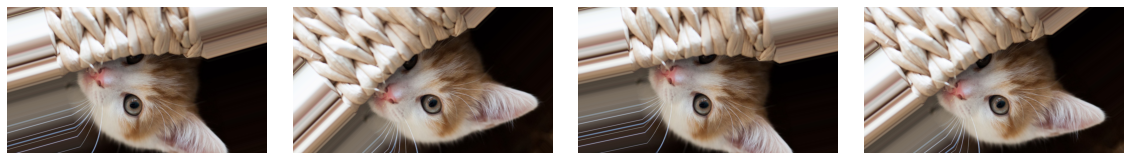

In [21]:
data_generator = ImageDataGenerator(rotation_range=90)
plot_augmentation(data_generator)

---
## 2 - Width Shifting
The `width_shift_range` is a floating point number between 0.0 and 1.0 which specifies the upper bound of the fraction of the total width by which the image is to be randomly shifted, either towards the left or right.

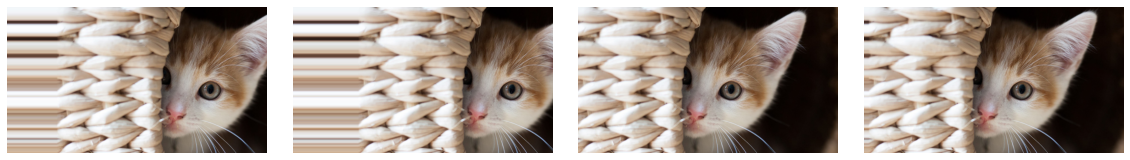

In [22]:
data_generator = ImageDataGenerator(width_shift_range=0.3)
plot_augmentation(data_generator)


---
## 3 - Height  Shifting
Exactly like width shifting, except that the image is shifted vertically instead of horizontally.

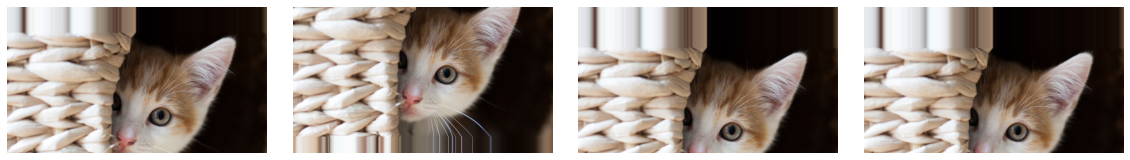

In [23]:
data_generator = ImageDataGenerator(height_shift_range=0.3)
plot_augmentation(data_generator)


---
## 4 - Brightness
The `brightness_range` specifies the range for randomly picking a brightness shift value from. A brightness of 0.0 corresponds to absolutely no brightness, and 1.0 corresponds to maximum brightness.

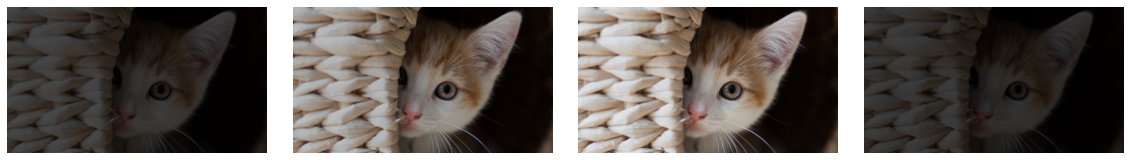

In [24]:
data_generator = ImageDataGenerator(brightness_range=(0.1, 0.9))
plot_augmentation(data_generator)


---
## 5 - Shear Intensity
Shear transformation slants the shape of the image. This is different from rotation in the sense that in shear transformation, we fix one axis and stretch the image at a certain angle known as the shear angle. This creates a sort of ‘stretch’ in the image, which is not seen in rotation. `shear_range` specifies the angle of the slant in degrees.

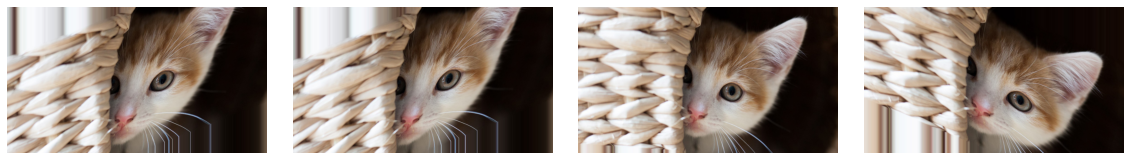

In [25]:
data_generator = ImageDataGenerator(shear_range=45.0)
plot_augmentation(data_generator)


---
## 6 - Zoom
A random zoom is obtained by the `zoom_range` argument. A zoom less than 1.0 magnifies the image, while a zoom greater than 1.0 zooms out of the image.

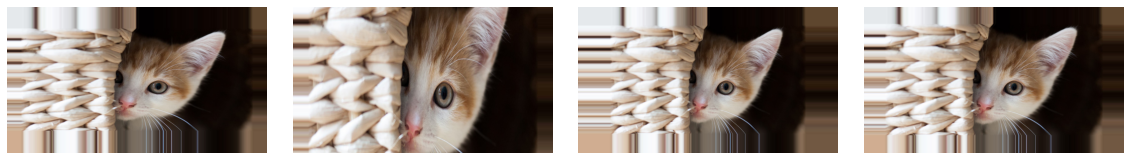

In [26]:
data_generator = ImageDataGenerator(zoom_range=[0.5, 1.5])
plot_augmentation(data_generator)


---
## 7 - Channel Shift
Channel shift randomly shifts the channel values by a random value chosen from the range specified by channel_shift_range.

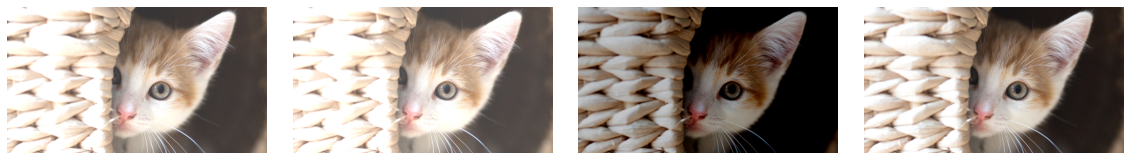

In [27]:
data_generator = ImageDataGenerator(channel_shift_range=150.0)
plot_augmentation(data_generator)


---
## 8 - Horizontal Flip
The generator will generate images, which on a random basis, will be horizontally flipped.

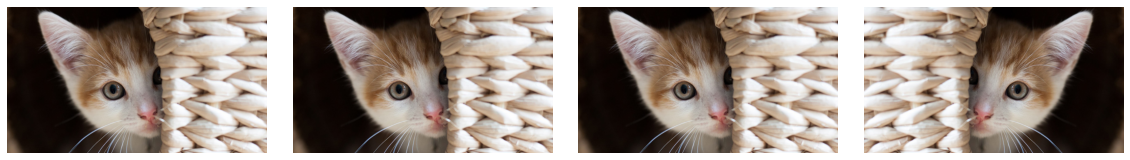

In [28]:
data_generator = ImageDataGenerator(horizontal_flip=True)
plot_augmentation(data_generator)


---
## 9 - Vertical Flip
nstead of flipping horizontally, we can also apply a vertical flip.

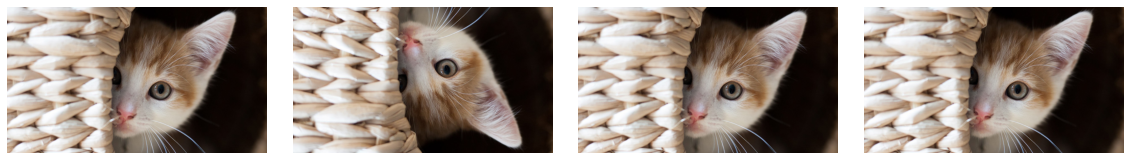

In [29]:
data_generator = ImageDataGenerator(vertical_flip=True)
plot_augmentation(data_generator)


---
## 10 - Nearest Pixel Fill
Notice that when we augment the image, TensorFlow fill the empty spaces with the last neighboring pixels from the image. This is called as nearest fill mode. This is the default option where the closest pixel value is chosen and repeated for all the empty values

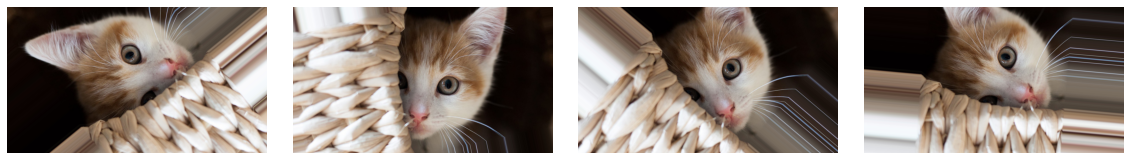

In [30]:
data_generator = ImageDataGenerator(rotation_range=180, fill_mode='nearest')
plot_augmentation(data_generator)

---
## 11 - Replect Pixel Fill
Another mode is the reflex fill mode. This mode creates a ‘reflection’ and fills the empty values in a reverse order of the known values.

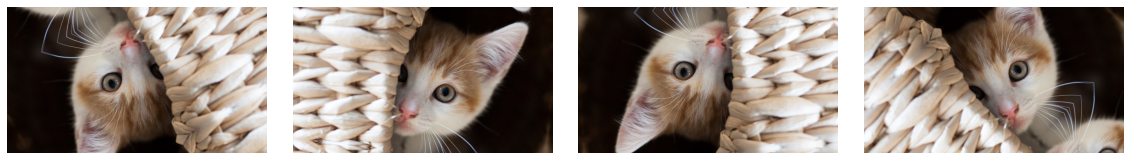

In [31]:
data_generator = ImageDataGenerator(rotation_range=180, fill_mode='reflect')
plot_augmentation(data_generator)

---
## 12 - Wrap Pixel Fill
The third one is called Wrap. Instead of a reflect effect, we can also create a ‘wrap’ effect by copying the values of the known points into the unknown points, keeping the order unchanged.

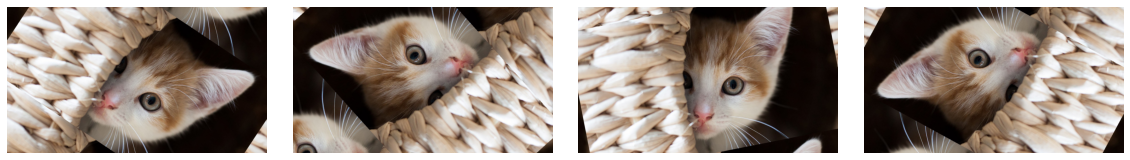

In [32]:
data_generator = ImageDataGenerator(rotation_range=180, fill_mode='wrap')
plot_augmentation(data_generator)

---
## 13 - Constant Pixel Fill
The last one is if we want to fill all the points lying outside the boundaries of the input by a constant value, this mode helps us achieve exactly that. The constant value is specified by the `cval` argument.

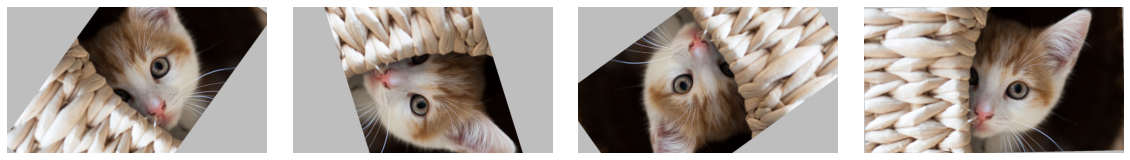

In [33]:
data_generator = ImageDataGenerator(rotation_range=180, fill_mode='constant', cval=190)
plot_augmentation(data_generator)

---
## 14 - Combine it all
Now, let's try and see how all the augmentation options combine

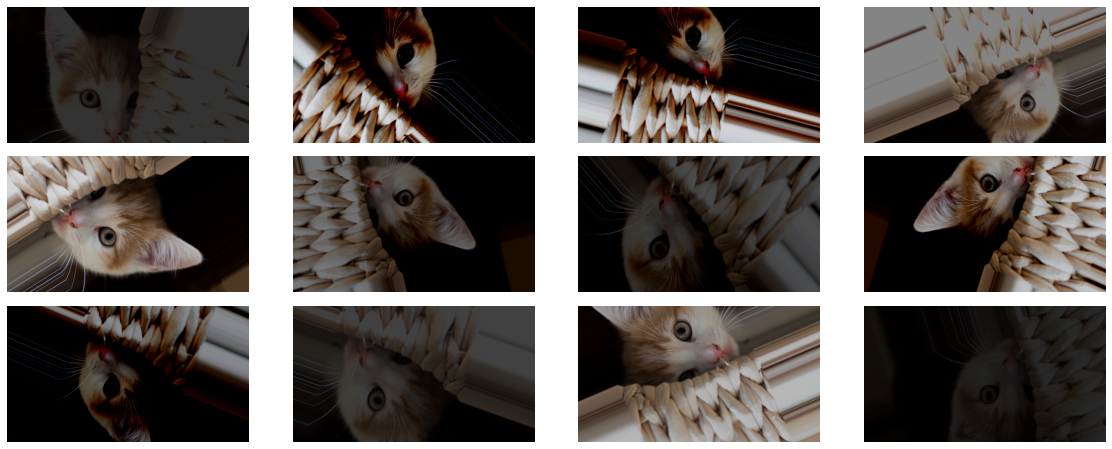

In [34]:
data_generator = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.1, 0.9),
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=150.0,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
    )

plot_augmentation(data_generator, nrows=3, ncols=4, figsize=(20,8))

---
---
# [Part 4] Training with Augmentation

After you master the Augmentation options, now let's train a new model, with the same architecture, but using Augmentation process

---
## 1 - Build Model

#### <font color='red'>**EXERCISE:** </font>
Build a new model by calling `create_model()` function. 


In [35]:
model_aug = create_model()

---
## 2 - Compile Model

#### <font color='red'>**EXERCISE:** </font>
compile your model using `'categorical_crossentropy'` loss, `'adam'` optimizer, and `['accuracy']` metrics


In [36]:
model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

---
## 3 - Train Data Generator
Now let's define our Data Generator to generate batches of tensor image data with real-time data augmentation. 

For starter, let's not get too wild on the Augmentation, and only use 3 options: width shift, height shift, and horizontal flip

#### <font color='red'>**EXERCISE:** </font>
create Image Data Generator with:
* width_shift_range=0.1,
* height_shift_range=0.1,
* horizontal_flip=True,


In [37]:
train_datagen = ImageDataGenerator(
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True
)


Now call `.fit()` function to Fits the data generator to some sample data.

In [38]:
train_datagen.fit(X_train)

To use the generator, we can use `.flow()` function to continuously read a batch of data, augment it in real time, and feed it into training loop.

You can call the `.flow()` function directly inside the training `.fit()` function, but it's also cleaner if we define as a named function outside like this.



In [39]:
batch_size = 256

train_generator = train_datagen.flow(
        X_train, y_train_hot, batch_size=batch_size
    )

---
## 4 - Train Model

#### <font color='red'>**EXERCISE:** </font>
Train the model for `20` epochs.<br>
Put `train_generator` in place for training data.<br>
You don't need to add batch number to the function.<br>
Don't forget to put the validation data.<br>
Use the one-hot label.


In [40]:
num_epochs = 20

history_aug = model_aug.fit(train_generator, 
                            validation_data=(X_val, y_val_hot),
                            epochs=num_epochs)

Epoch 1/20
157/157 [==============================] - 16s 100ms/step - loss: 1.5682 - accuracy: 0.4404 - val_loss: 1.2901 - val_accuracy: 0.5393
Epoch 2/20
157/157 [==============================] - 16s 99ms/step - loss: 1.2244 - accuracy: 0.5681 - val_loss: 1.1219 - val_accuracy: 0.6093
Epoch 3/20
157/157 [==============================] - 16s 100ms/step - loss: 1.0978 - accuracy: 0.6152 - val_loss: 1.0350 - val_accuracy: 0.6492
Epoch 4/20
157/157 [==============================] - 16s 99ms/step - loss: 1.0130 - accuracy: 0.6470 - val_loss: 0.9950 - val_accuracy: 0.6589
Epoch 5/20
157/157 [==============================] - 16s 99ms/step - loss: 0.9540 - accuracy: 0.6680 - val_loss: 0.8766 - val_accuracy: 0.7008
Epoch 6/20
157/157 [==============================] - 16s 101ms/step - loss: 0.9072 - accuracy: 0.6830 - val_loss: 0.8793 - val_accuracy: 0.7039
Epoch 7/20
157/157 [==============================] - 16s 99ms/step - loss: 0.8622 - accuracy: 0.6992 - val_loss: 0.8920 - val_accura

**EXPECTED OUTPUT**:

<pre>The loss should start from ~1.5 and end around 0.6 
the training accuracy only reach 78%, but the validation accuracy should stay close to it

---
## 5 - Evaluate Model


#### <font color='red'>**EXERCISE:** </font>
Evaluate model using data test. <br>
Use the one-hot label.


In [41]:
scores_aug = model_aug.evaluate(X_test, y_test_hot, verbose=1)

print("\nModel Accuracy: %.2f%%" % (scores_aug[1]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.7162 - accuracy: 0.7688

Model Accuracy: 76.88%


**EXPECTED OUTPUT**:
<pre>
you should get around 75% of testing accuracy

---
## 6 - Visualize Training History

Visualize the train-validation accuracy

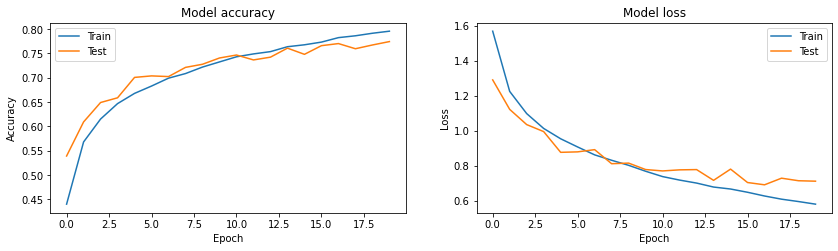

In [42]:
plot_history(history_aug)

You should see that the training and validation accuracy, as well the loss is still close. Indicates that we can continue the training a bit longet.

---
---
# [Part 5] Comparison

Now let's compare the two networks in terms of accuracy and loss

---
## 1 - Training Loss and Accuracy

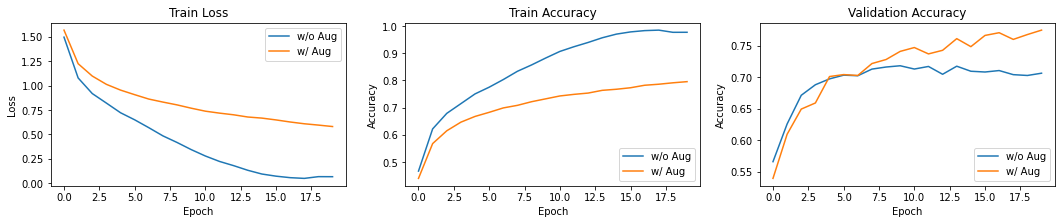

In [43]:
fig, ax = plt.subplots(1,3,figsize=(18,3))

ax[0].plot(history_no_aug.history['loss'])
ax[0].plot(history_aug.history['loss'])
ax[0].set_title('Train Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['w/o Aug', 'w/ Aug'], loc='upper right')

ax[1].plot(history_no_aug.history['accuracy'])
ax[1].plot(history_aug.history['accuracy'])
ax[1].set_title('Train Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['w/o Aug', 'w/ Aug'], loc='lower right')

ax[2].plot(history_no_aug.history['val_accuracy'])
ax[2].plot(history_aug.history['val_accuracy'])
ax[2].set_title('Validation Accuracy')
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].legend(['w/o Aug', 'w/ Aug'], loc='lower right')
plt.show()

You should see that the model trained without Augmentation has higher accuracy (and lower loss) compared to the model trained with Augmentation. This happens because the Augmented model has to see much more data per epoch, which makes it harder to generalize. 

However, if we see the validation accuracy, the model trained with augmentation has higher accuracy.

---
## 2 - Overfitting Comparison
Now if we compare the model overfitting

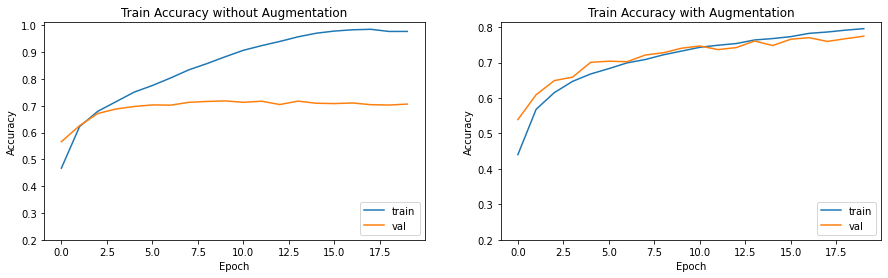

In [44]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

ax[0].plot(history_no_aug.history['accuracy'])
ax[0].plot(history_no_aug.history['val_accuracy'])
ax[0].set_title('Train Accuracy without Augmentation')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(bottom=.2)
ax[0].legend(['train', 'val'], loc='lower right')

ax[1].plot(history_aug.history['accuracy'])
ax[1].plot(history_aug.history['val_accuracy'])
ax[1].set_title('Train Accuracy with Augmentation')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(bottom=.2)
ax[1].legend(['train', 'val'], loc='lower right')
plt.show()

You can see that augmentation may prevent the overfitting. 

If the gap of loss and accuracy between training and validation is still small, it means that we can train the network longer, or even increase the capacity (e.g. add more layers) to improve its performance

---
## 3 - Testing Accuracy

Lastly, we should see that the testing accuracy is also higher

In [45]:
print("Test Accuracy without Augmentation : %.2f%%" % (scores_no_aug[1]*100))
print("Test Accuracy with Augmentation    : %.2f%%" % (scores_aug[1]*100))

Test Accuracy without Augmentation : 69.05%
Test Accuracy with Augmentation    : 76.88%


---
---
# [Part 6] CIFAR-10 Open-ended Challenge

Similar to the previous exercise, in this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. You should experiment with **architectures**, **hyperparameters**, **loss functions**, **regularization**, or anything else you can think of to train a model 

but now, add <font color='blue' size='4' ><b>Augmentation</b></font> to the mix



---
## Some things you can try:
- **Filter size**
- **Number of filters**
- **Pooling**
- **Normalization**
- **Network architecture**
- **Global average pooling**
- **Regularization**
- **Optimization**


---
## Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. 

When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations

- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.

- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

<center>
<h2><font color='blue'>--- Go Wild, Have Fun, and Happy Training!  --- </font></h2>

---
## 1 - Define Model

---
#### <font color='red'>**EXERCISE:** </font>

    Design your Convolutional Neural Network Architecture

    

In [50]:
from tensorflow.keras.layers import *

myModel = Sequential([
        Conv2D(16, (5,5), padding='same', activation='relu', input_shape=(32,32,3)),
        Conv2D(32, (5,5), padding='same', activation='relu'),
        Conv2D(64, (5,5), padding='same', activation='relu'),
        MaxPool2D(),
        Conv2D(64, (5,5), padding='same', activation='relu'),
        Conv2D(128, (5,5), padding='same', activation='relu'),
        Conv2D(256, (5,5), padding='same', activation='relu'),
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ], name='my_model')


myModel.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        12832     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        102464    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 256)       819

---
## 2 - Augment Data

---
#### <font color='red'>**EXERCISE:** </font>

    Define Data Augmentation generator
    

In [51]:
train_datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  zoom_range=[0.5, 1.5]
)


train_datagen.fit(X_train)

In [52]:
batch_size = 200

train_generator = train_datagen.flow(
    X_train, y_train_hot, batch_size=batch_size
)

---
## 2 - Train Model

---
#### <font color='red'>**EXERCISE:** </font>

    Compile the model
    Train the model
    

In [53]:
# Compile model
myModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

num_epochs = 100

history = myModel.fit(train_generator, 
                      validation_data=(X_val, y_val_hot),
                      epochs=num_epochs)


Epoch 1/100
200/200 [==============================] - 21s 103ms/step - loss: 1.9949 - accuracy: 0.2351 - val_loss: 1.7813 - val_accuracy: 0.3094
Epoch 2/100
200/200 [==============================] - 20s 102ms/step - loss: 1.8152 - accuracy: 0.3057 - val_loss: 1.7196 - val_accuracy: 0.3445
Epoch 3/100
200/200 [==============================] - 20s 102ms/step - loss: 1.6897 - accuracy: 0.3633 - val_loss: 1.6602 - val_accuracy: 0.3641
Epoch 4/100
200/200 [==============================] - 20s 101ms/step - loss: 1.5871 - accuracy: 0.4114 - val_loss: 1.5329 - val_accuracy: 0.4172
Epoch 5/100
200/200 [==============================] - 21s 104ms/step - loss: 1.5213 - accuracy: 0.4414 - val_loss: 1.3513 - val_accuracy: 0.4951
Epoch 6/100
200/200 [==============================] - 20s 101ms/step - loss: 1.4320 - accuracy: 0.4785 - val_loss: 1.4096 - val_accuracy: 0.4995
Epoch 7/100
200/200 [==============================] - 20s 101ms/step - loss: 1.3746 - accuracy: 0.5015 - val_loss: 1.1814 -

In [54]:
# Save model if needed
myModel.save('custom.h5')

---
## 3 - Evaluate Model

---
#### <font color='red'>**EXERCISE:** </font>

    evaluate your model on test set
    

In [60]:
from tensorflow.keras.models import load_model

myModel = load_model('custom.h5')

train_scores = myModel.evaluate(X_train, y_train_hot, verbose=1)
val_scores   = myModel.evaluate(X_val, y_val_hot, verbose=1)
test_scores  = myModel.evaluate(X_test, y_test_hot, verbose=1)

print("Training Accuracy  : %.2f%%" % (train_scores[1]*100))
print("Validation Accuracy: %.2f%%" % (val_scores[1]*100))
print("Testing Accuracy  :  %.2f%%" % (test_scores[1]*100))

313/313 [==============================] - 2s 5ms/step - loss: 0.6280 - accuracy: 0.8001
Training Accuracy  : 85.24%
Validation Accuracy: 80.66%
Testing Accuracy  :  80.01%


**EXPECTED OUTPUT**:
<pre>
try to get above 80% of accuracy for train, val, and test set

---
## 4 - Test Model on New Image

Test your model on new image

---
#### <font color='red'>**EXERCISE:** </font>

    define five image urls
    one image has been given for an example, you can change it

In [61]:
!wget -q -O 'data_test_0.jpg' 'https://ichef.bbci.co.uk/news/912/cpsprodpb/160B4/production/_103229209_horsea.png'
!wget -q -O 'data_test_1.jpg' 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ2i9sfizLcoa_0ZNDzWyNbHU10ZEnGRIq7NA&usqp=CAU' # Cat
!wget -q -O 'data_test_2.jpg' 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQCOXayQ1enKT5EYVzc4humtVBLpuM8EMtjQA&usqp=CAU' # Car
!wget -q -O 'data_test_3.jpg' 'https://globalnews.ca/wp-content/uploads/2020/02/airbusier-e1581533974496.jpg?quality=85&strip=all' # Plane
!wget -q -O 'data_test_4.jpg' 'https://akcdn.detik.net.id/visual/2020/07/14/scooby-doo_169.png?w=650' # Dog

Run and Recognize the images

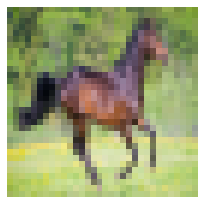

predicted id   : 7
predicted class: horse
--------------------------------




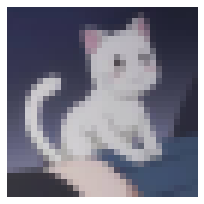

predicted id   : 5
predicted class: dog
--------------------------------




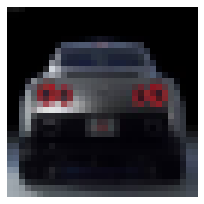

predicted id   : 1
predicted class: car
--------------------------------




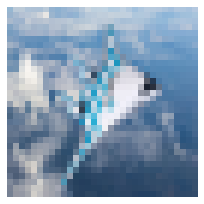

predicted id   : 0
predicted class: plane
--------------------------------




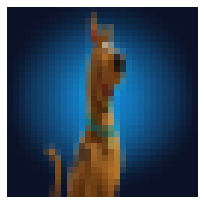

predicted id   : 2
predicted class: bird
--------------------------------




In [62]:
import cv2 as cv
from PIL import Image
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


for i in range(5):
    # load and open the image
    new_img = Image.open('data_test_'+str(i)+'.jpg')
    new_img = np.array(new_img)

    # resize into (32,32,3)
    new_img2 = cv.resize(new_img, (32,32), interpolation=cv.INTER_AREA)
    plt.imshow(new_img2)
    plt.axis('off')
    plt.show()

    # preprocess the image using X_train mean and std
    new_img2 = (new_img2 - mean_pixel) / std_pixel

    # predict the class
    pred = myModel.predict(new_img2)
    class_id = np.argmax(pred)
    print('predicted id   :',class_id)
    print('predicted class:', class_names[class_id])
    print('--------------------------------\n\n')


---

# Congratulation, You've Completed Exercise 6

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)